In [1]:
import wntr
import pandas as pd
import numpy as np
import scipy

In [2]:
from scripts.valves import *
from scripts.graph import *
from scripts.simulation import *

7456.9987200000005
Num nodes: 859 ;Num links: 985


/home/rewu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


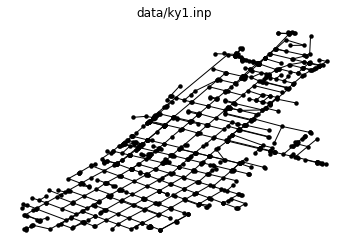

In [3]:
# Create a water network model
inp_file = 'data/ky1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wntr.graphics.plot_network(wn, title=wn.name)
n_node = len(wn.node_name_list)
n_link = len(wn.link_name_list)
print ("Num nodes:",n_node ,";Num links:", n_link)

In [4]:
inp_graph = wntr.sim.graph.NetworkRepresentor(wn)

In [5]:
inp_graph._model._node_id_to_name[0]

'J-1'

In [6]:
inp_graph._model._link_id_to_name[7]

'P-8'

In [7]:
def create_valves(lid2npair):
    vid = 0
    valves = []
    for lid, npairs in lid2npair.items():
        for nid in npairs:
            v = Valve(vid,nid,lid)
            vid += 1
            valves.append(v)
    return valves
        

In [8]:
valves = create_valves(inp_graph.lid2npair)
vreg = ValveRegister()
vreg.register(valves)

In [9]:
class SegmentSummary(object):
    def __init__(self,num_nodes,segments,A_diff,num_closed_pipes = 0):
        self.num_nodes = num_nodes
        self.segments = segments
        self.num_closed_pipes = num_closed_pipes
        self.pipe_sids = self._get_pipe_seg_ids()
        self.id2sid = self._get_id2sid()
        
        self.segment_graph = self.convert2seg_graph(A_diff)
        
    def _get_pipe_seg_ids(self):
        sids = []
        for seg in self.segments:
            if len(seg.pids):
                sids.append(seg.sid)
        return sids
    
    def _get_id2sid(self):
        id2sid ={}
        for sid, seg in enumerate(self.segments):
            for id in seg.ids:
                id2sid[id] = sid
        return id2sid
    
    def convert2seg_graph(self,A_diff):
        segment_graph = lil_matrix((len(self.segments), len(self.segments)), 
                                   dtype=np.int8)
        for i in range(A_diff.shape[0]):
            searching_sid = self.id2sid[i]
            nearby_ids = np.nonzero(A_diff[i,:])[1]
            for nearby_id in nearby_ids:
                nearby_sid = self.id2sid[nearby_id]
                segment_graph[searching_sid,nearby_sid] = 1  
                segment_graph[nearby_sid,searching_sid] = 1  
        return segment_graph
    
    
    def _get_unintend_consequence(self,segment_graph,iso_sids):
        components = bfs(segment_graph)
        unintend_consequence = 0
        for iso_component in components[1:]:
            for sid in iso_component:
                if sid not in iso_sids:
                    seg = self.segments[sid]
                    unintend_consequence += len(seg.pids)
#         print (iso_sids,components[0],unintend_consequence,self.num_closed_pipes)
        unintend_consequence -= self.num_closed_pipes
        
        return unintend_consequence
        
    def _iso_on_segment_graph(self,segment_graph,sid):
        segment_graph[sid,:] = 0
        segment_graph[:,sid] = 0
        return segment_graph
    
    def _iso_consequence(self,sids):
        segment_graph = self.segment_graph.copy()
        direct_consequence = 0
        for sid in sids:
            seg = self.segments[sid]
            direct_consequence += len(seg.pids)
            segment_graph = self._iso_on_segment_graph(segment_graph,sid)
        unintend_consequence = self._get_unintend_consequence(segment_graph,sids)
        return direct_consequence,unintend_consequence
        
    
    def pipe_iso_consequences(self,pids):
        direct_consequences = []
        unintend_consequences = []
        for pid in pids:
            id = self.num_nodes + pid
            sid = self.id2sid[id]
            direct,unintened = self._iso_consequence([sid])
            direct_consequences.append(direct)
            unintend_consequences.append(unintened)
        return np.array(direct_consequences),np.array(unintend_consequences)
            
                
    def _multi_pipe_iso_consequence(self,pids2close):
        sids = []
        for pid in pids2close:
            id = self.num_nodes + pid
            sids.append(self.id2sid[id])
        return self._iso_consequence(sids)
    
    
    def multi_pipe_iso_consequences(self,valid_pids,degree,num_sim = 100):
        np.random.seed()
        pids2close_pool = [np.random.choice(list(valid_pids),degree,replace = False) for _ in range(num_sim)]
        directs, unintends = [], []
        for pids2close in pids2close_pool:
            direct, unintend = self._multi_pipe_iso_consequence(pids2close)
            directs.append(direct)
            unintends.append(unintend)
        return np.mean(directs),np.mean(unintends)



In [10]:
def find_segments(A, num_nodes):
    segments = []
    components = bfs(A)
    for i, component in enumerate(components):
        segment = create_segment(i, component,num_nodes)
        segments.append(segment)
    return segments

In [11]:
def simulate_segments(vreg,valves_dict):
    nnodes = len(vreg.nid2v)
    npipes = len(vreg.pid2v)
    A = assemble_adjacency_mtx(nnodes,npipes, valves_dict)
    segments = find_segments(A,nnodes)
    return segments

def create_mtx_diff(vreg, valves_dict):
    nnodes = len(vreg.nid2v)
    npipes = len(vreg.pid2v)
    valid_vids = vreg.vid2v.keys()
    
    A = assemble_adjacency_mtx(nnodes,npipes,valves_dict)
    null_valves = create_null_valves_dict(valves_dict,valid_vids)
    A_null = assemble_adjacency_mtx(nnodes,npipes,null_valves)
    A_diff = A_null - A
    return A_diff



In [12]:
def generate_seg_sum(vreg,vfail_rate):
    vreg.recover_valves()
    vids2fail = generate_vids2fail(vreg.valid_vids,vfail_rate)
    valves_dict = fail_valves(vreg.vid2v,vids2fail)
    num_nodes = len(vreg.nid2v)
    segments = simulate_segments(vreg,valves_dict)
    mtx_diff = create_mtx_diff(vreg,valves_dict)
    seg_sum = SegmentSummary(num_nodes,segments,mtx_diff)
    return seg_sum

In [13]:
pids2sim = set(vreg.pid2v.keys())
pids2sim.remove(143)
pids2sim = list(pids2sim)

In [14]:
vfail_rates = np.linspace(0,1,10)

In [ ]:
seg_sum = generate_seg_sum(vreg,0.25)
direct,unintend = seg_sum.pipe_iso_consequences(pids2sim)
tot = direct+unintend

In [21]:
seg_sum = generate_seg_sum(vreg,0)
seg_sum.pipe_iso_consequences([30])

(array([1]), array([0]))

In [34]:
inp_graph._model._link_id_to_name[34]

'PIPE-80762'

In [14]:
for vfail_rate in vfail_rates:
    seg_sum = generate_seg_sum(vreg,vfail_rate)
    direct,unintend = seg_sum.pipe_iso_consequences(pids2sim)
    tot = direct+unintend

    print (vfail_rate,np.mean(direct),np.mean(unintend),np.mean(tot))

0.0 1.0 0.4829059829059829 1.482905982905983
0.1111111111111111 1.0683760683760684 0.5170940170940171 1.5854700854700854
0.2222222222222222 1.1025641025641026 1.6025641025641026 2.7051282051282053
0.3333333333333333 1.3247863247863247 0.7393162393162394 2.0641025641025643
0.4444444444444444 1.705128205128205 1.5341880341880343 3.2393162393162394
0.5555555555555556 2.247863247863248 2.5641025641025643 4.811965811965812
0.6666666666666666 3.8504273504273505 1.9914529914529915 5.8418803418803416
0.7777777777777777 7.662393162393163 15.61111111111111 23.273504273504273
0.8888888888888888 30.243589743589745 21.141025641025642 51.38461538461539
1.0 235.0 0.0 235.0


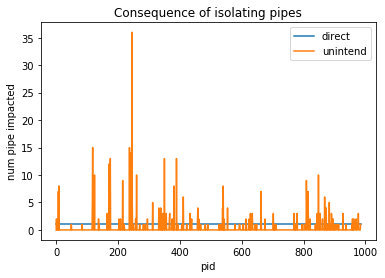

In [25]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(pids2sim, direct, label="direct")
plt.plot(pids2sim, unintend, label="unintend")
# plt.plot(pids2sim, tot, label="tot")
plt.title(f'Consequence of isolating pipes')
#     plt.bar(pids2sim, direct_ratio+unintend_ratio, label="tot")

plt.xlabel('pid')
plt.ylabel('num pipe impacted')
plt.legend()
plt.show()

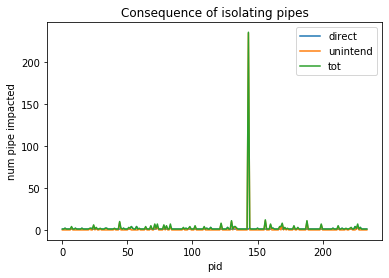

In [63]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(pids2sim, direct, label="direct")
plt.plot(pids2sim, unintend, label="unintend")
plt.plot(pids2sim, tot, label="tot")
plt.title(f'Consequence of isolating pipes')
#     plt.bar(pids2sim, direct_ratio+unintend_ratio, label="tot")

plt.xlabel('pid')
plt.ylabel('num pipe impacted')
plt.legend()
plt.show()

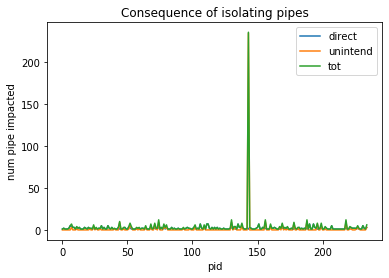

In [67]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(pids2sim, direct, label="direct")
plt.plot(pids2sim, unintend, label="unintend")
plt.plot(pids2sim, tot, label="tot")
plt.title(f'Consequence of isolating pipes')
#     plt.bar(pids2sim, direct_ratio+unintend_ratio, label="tot")

plt.xlabel('pid')
plt.ylabel('num pipe impacted')
plt.legend()
plt.show()